In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import IPython.display as ipd
from model.resnet import resnet152, resnet34

from utils.dataloader import CaptchaDataset

from sklearn.model_selection import train_test_split
import os

# hyperparameter

In [2]:
EPOCHS = 5
CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if CUDA else 'cpu'
MODEL_PATH = './weights/resnet34_ceal'
INIT_MODEL_PATH = './weights/resnet34_ceal_init'
BATCH_SIZE = 4
PATIENCE = 10

In [3]:
INITIAL_ANNOTATED_PERCENT = 0.1
MAXIMUM_ITERATIONS = 30
THRESHOLD_DECAY = 0.0033
_DELTA = 0.05
UNCERTAIN_SAMPLES_SIZE = 1000
UNCERTAIN_CRITERIA = 'lc'
COST_EFFECTIVE = True
FINE_TUNNING_INTERVAL = 1

# dataloader

In [4]:
image_transform = transforms.Compose([
    # transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = CaptchaDataset('./Large_Captcha_Dataset', isFilter=True, isCrop=True)

In [5]:
pool_size = int(0.8 * len(dataset))
test_size = len(dataset) - pool_size
pool_dataset, test_dataset = torch.utils.data.random_split(dataset, [pool_size, test_size])

In [6]:
pool_size = int(0.9 * len(pool_dataset))
init_size = len(pool_dataset)-pool_size
pool_dataset, init_dataset = torch.utils.data.random_split(pool_dataset, [pool_size, init_size])

In [7]:
pool_dataloader = DataLoader(pool_dataset, batch_size=BATCH_SIZE, shuffle=True)
init_dataloader = DataLoader(init_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# model

In [7]:
model = resnet34()

In [8]:
if CUDA:
    model = model.cuda()

# train

In [8]:
loss_history = []
val_loss_history = []

In [9]:
def train(model, train_dataloader):
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    min_loss = 20.
    stop_cnt = 0
    for e in range(EPOCHS):
        start_time = time.time()
        current_loss = []
        current_val_loss = []

        for (x, y) in tqdm(train_dataloader):
            optimizer.zero_grad()
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

            pred1, pred2, pred3, pred4, pred5 = model(x)

            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        current_loss = np.mean(current_loss).item()
        loss_history.append(current_loss)

        if current_loss < min_loss:
            min_loss = current_loss
            torch.save(model.state_dict(), MODEL_PATH)

        ipd.clear_output(wait=True)
        print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
        print(f"current loss={current_loss:.4f}")
        plt.figure(figsize=(20,1),dpi=120)
        plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
        plt.legend(loc=1)
        plt.show()


# test

In [20]:
model.eval()
model.load_state_dict(torch.load(MODEL_PATH))
'done'

'done'

In [10]:
def evaluate(model, test_dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    pred_list = [[] for i in range(5)]
    true_list = [[] for i in range(5)]
    current_loss = []

    for (x, y) in tqdm(test_dataloader):
        with torch.no_grad():
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

            pred1, pred2, pred3, pred4, pred5 = model(x)
            
            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_loss.append(loss.item())
            
            
            pred1 = torch.argmax(pred1, -1)
            pred2 = torch.argmax(pred2, -1)
            pred3 = torch.argmax(pred3, -1)
            pred4 = torch.argmax(pred4, -1)
            pred5 = torch.argmax(pred5, -1)
            

            pred_list[0] += pred1.detach().cpu().tolist()
            pred_list[1] += pred2.detach().cpu().tolist()
            pred_list[2] += pred3.detach().cpu().tolist()
            pred_list[3] += pred4.detach().cpu().tolist()
            pred_list[4] += pred5.detach().cpu().tolist()

            true_list[0] += y1.detach().cpu().tolist()
            true_list[1] += y2.detach().cpu().tolist()
            true_list[2] += y3.detach().cpu().tolist()
            true_list[3] += y4.detach().cpu().tolist()
            true_list[4] += y5.detach().cpu().tolist()
            
    pred_list = np.array(pred_list)
    true_list = np.array(true_list)

    loss = np.mean(current_loss).item()
    accuracy = np.sum(pred_list==true_list, axis=1)/true_list.shape[-1]
    
    return loss, accuracy

# CEAL

In [11]:
def initialize_model(init_dataloader, test_dataloader):
    model = resnet34()
    if CUDA:
        model = model.cuda()
    if os.path.exists(INIT_MODEL_PATH):
        model.load_state_dict(torch.load(INIT_MODEL_PATH))
    else:
        train(model, init_dataloader)
        torch.save(model.state_dict(), INIT_MODEL_PATH)
    loss, acc = evaluate(model, test_dataloader)
    print('Initial Test Loss: ', loss, '\nInitial Test Accuracy: ', acc)
    return model

In [12]:
# Random sampling
def random_sampling(y_pred_prob, n_samples):
    return np.random.choice(range(len(y_pred_prob)), n_samples)

In [13]:
# Rank all the unlabeled samples in an ascending order according to the least confidence
def least_confidence(y_pred_prob, n_samples):
    origin_index = np.arange(0, len(y_pred_prob))
    max_prob = np.max(y_pred_prob, axis=1)
    pred_label = np.argmax(y_pred_prob, axis=1)

    lci = np.column_stack((origin_index,
                           max_prob,
                           pred_label))
    lci = lci[lci[:, 1].argsort()]
    return lci[:n_samples], lci[:, 0].astype(int)[:n_samples]

In [14]:
# Rank all the unlabeled samples in an ascending order according to the margin sampling
def margin_sampling(y_pred_prob, n_samples):
    origin_index = np.arange(0, len(y_pred_prob))
    margim_sampling = np.diff(-np.sort(y_pred_prob)[:, ::-1][:, :2])
    pred_label = np.argmax(y_pred_prob, axis=1)
    msi = np.column_stack((origin_index,
                           margim_sampling,
                           pred_label))
    msi = msi[msi[:, 1].argsort()]
    return msi[:n_samples], msi[:, 0].astype(int)[:n_samples]

In [15]:
# Rank all the unlabeled samples in an descending order according to their entropy
def entropy(y_pred_prob, n_samples):
    # entropy = stats.entropy(y_pred_prob.T)
    # entropy = np.nan_to_num(entropy)
    origin_index = np.arange(0, len(y_pred_prob))
    entropy = -np.nansum(np.multiply(y_pred_prob, np.log(y_pred_prob)), axis=1)
    pred_label = np.argmax(y_pred_prob, axis=1)
    eni = np.column_stack((origin_index,
                           entropy,
                           pred_label))

    eni = eni[(-eni[:, 1]).argsort()]
    return eni[:n_samples], eni[:, 0].astype(int)[:n_samples]

In [16]:
def get_high_confidence_samples(y_pred_prob, delta):
    eni, eni_idx = entropy(y_pred_prob, len(y_pred_prob))
    hcs = eni[eni[:, 1] < delta]
    return hcs[:, 0].astype(int), hcs[:, 2].astype(int)

In [17]:
def get_uncertain_samples(y_pred_prob, n_samples, criteria):
    if criteria == 'lc':
        return least_confidence(y_pred_prob, n_samples)
    elif criteria == 'ms':
        return margin_sampling(y_pred_prob, n_samples)
    elif criteria == 'en':
        return entropy(y_pred_prob, n_samples)
    elif criteria == 'rs':
        return None, random_sampling(y_pred_prob, n_samples)
    else:
        raise ValueError(
            'Unknown criteria value \'%s\', use one of [\'rs\',\'lc\',\'ms\',\'en\']' % criteria)

In [22]:
def run_ceal():
    model = initialize_model(init_dataloader, test_dataloader)
    _DELTA = 0.05
    
    for i in range(MAXIMUM_ITERATIONS):
        y_pred_probs = []
        for (x, y) in tqdm(pool_dataloader):
            x = x.to(DEVICE)
            y_pred_prob = model(x)
            y_pred_prob = list(map(lambda _y: _y.detach().cpu().numpy(), y_pred_prob))
            # y_pred_prob = y_pred_prob.detach().cpu().numpy()
            y_pred_probs.append(y_pred_prob)

            break
        y_pred_probs = np.array(y_pred_probs)
        y_pred_probs = np.transpose(y_pred_probs, (0, 2, 1, 3)).reshape(-1, 5, 62)

        _, un_idx = get_uncertain_samples(y_pred_probs, UNCERTAIN_SAMPLES_SIZE, criteria=UNCERTAIN_CRITERIA)
        
        un_idx = [pool_dataloader.sampler.data_source.indices[idx] for idx in un_idx]
        
        init_dataloader.sampler.data_source.indices.extend(un_idx)
        
        if COST_EFFECTIVE:
            hcs_idx, hcs_labels = get_high_confidence_samples(y_pred_prob, _DELTA)
            
            hcs_idx = [pool_dataloader.sampler.data_source.indices[idx] for idx in hcs_idx]
            
            hcs_idx = [x for x in hcs_idx if x not in list(set(un_idx) & set(hcs_idx))]
            
            init_dataloader.sampler.data_source.indices.extend(hcs_idx)
            
            for idx in range(len(hcs_idx)):
                init_dataloader.dataset.dataset.dataset.y[hcs_idx[idx]] = hcs_labels[idx]
        
        if i % FINE_TUNNING_INTERVAL == 0 :
            train(model, init_dataloader)
            _DELTA -= (THRESHOLD_DECAY * FINE_TUNNING_INTERVAL)
        
        for val in un_idx:
            pool_dataloader.sampler.data_source.indices.remove(val)
        
        _, acc = evaluate(model, test_dataloader)
        
        print(
            "Iteration: {}, len(dl): {}, len(du): {},"
            " len(dh) {}, acc: {} ".format(
                i, len(init_dataloader.sampler.data_source.indices),
                len(pool_dataloader.sampler.data_source.indices), len(hcs_idx), acc))



4/5, 42.39 sec/epoch
current loss=12.4754


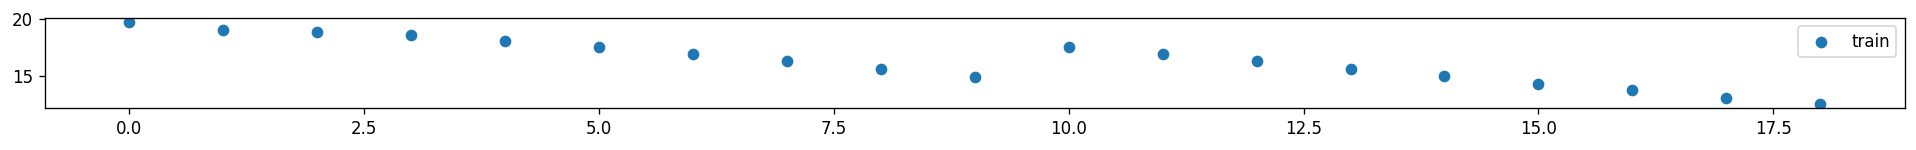

 47%|██████████████████▊                     | 776/1651 [00:19<00:22, 38.70it/s]

In [ ]:
run_ceal()

# visalization

In [33]:
keys = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

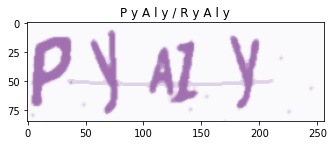

In [49]:
for (x, y) in test_dataloader:
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        y1 = list(map(lambda x: keys[x], y1))
        y2 = list(map(lambda x: keys[x], y2))
        y3 = list(map(lambda x: keys[x], y3))
        y4 = list(map(lambda x: keys[x], y4))
        y5 = list(map(lambda x: keys[x], y5))
        
        pred1 = list(map(lambda x: keys[x], pred1))
        pred2 = list(map(lambda x: keys[x], pred2))
        pred3 = list(map(lambda x: keys[x], pred3))
        pred4 = list(map(lambda x: keys[x], pred4))
        pred5 = list(map(lambda x: keys[x], pred5))
        
        
        for idx in range(BATCH_SIZE):
            true_str = f'{y1[idx]} {y2[idx]} {y3[idx]} {y4[idx]} {y5[idx]}'
            pred_str = f'{pred1[idx]} {pred2[idx]} {pred3[idx]} {pred4[idx]} {pred5[idx]}'
            plt.figure(figsize=(50,50))
            plt.subplot(8, 8, idx+1)
            plt.title(f'{true_str} / {pred_str}')
            plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        break